# Age Estimation using VGG16

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.models import load_model
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.utils import shuffle

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

%matplotlib inline

from PIL import Image
import shutil

## Age estimation in age groups

### Set image size and variables 

In [2]:
IMAGE_SIZE = [224,224]
TRAIN_TEST_SPLIT = 0.3
BASE_DIR = '../input/utkface-new/UTKFace/'
NR_EPOCHS = 60

### Define methods map direct age to classes

In [3]:
def age_to_class( age ):
  age_class = None
  # 0 (0-20)
  if 0 <= age <= 20:
    age_class = 0
  # 1 (20-40)
  if 20 < age <= 40:
    age_class = 1
  # 2 (40-60)
  if 40 < age <= 60:
    age_class = 2
  # 3 (40-60)
  if 60 < age <= 80:
    age_class = 3
  # 3 (80+)
  if age > 80:
    age_class = 4
  return age_class

# map age classes for age gaps
age_dict = {0:'0-20', 1:'20-40',2:'40-60', 3:'60-80', 4:'80+'}

def decode_age_label(age_id):
  return age_dict[int(age_id)]

### Read input dataset

In [4]:
# read labels of image age, gender
image_paths = []
age_labels = []
gender_labels =[]
age_class = []

for filename in tqdm(os.listdir(BASE_DIR)):
  #read image path
  image_path = os.path.join(BASE_DIR, filename)
  #split filename to extract labels
  temp= filename.split('_')
  age = int(temp[0])
  gender = int(temp[1])
  image_paths.append(image_path)
  age_labels.append(age)
  gender_labels.append(gender)
  age_class.append(age_to_class(age))

# extract name of file 
names = []
for path in image_paths:
  temp = path.split('/')
  names.append(temp[4])

#convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['age_class'], df['name'] = image_paths, age_labels, gender_labels, age_class, names
df.head()
df

# get and print the number of images in dataframe
age_verbose = [age_dict[int(age)] for age in df['age_class']]

print(Counter(age_verbose))



  0%|          | 0/23708 [00:00<?, ?it/s]

Counter({'20-40': 12123, '0-20': 4877, '40-60': 4311, '60-80': 1857, '80+': 540})


### Shuffle dataset

In [5]:
# shuffle dataset 
df = shuffle(df)

In [6]:
# check dataframe
df 

,image,age,gender,age_class,name
5142,../input/utkface-new/UTKFace/36_0_0_2017011720...,36,0,1,36_0_0_20170117202645622.jpg.chip.jpg
20573,../input/utkface-new/UTKFace/26_1_0_2017010318...,26,1,1,26_1_0_20170103181710200.jpg.chip.jpg
7114,../input/utkface-new/UTKFace/16_0_0_2017011620...,16,0,0,16_0_0_20170116201106640.jpg.chip.jpg
15795,../input/utkface-new/UTKFace/30_0_0_2017011622...,30,0,1,30_0_0_20170116223816127.jpg.chip.jpg
14875,../input/utkface-new/UTKFace/54_1_0_2017011717...,54,1,2,54_1_0_20170117171154110.jpg.chip.jpg
...,...,...,...,...,...
19518,../input/utkface-new/UTKFace/28_0_1_2017011315...,28,0,1,28_0_1_20170113151400128.jpg.chip.jpg
5288,../input/utkface-new/UTKFace/21_1_0_2017010423...,21,1,1,21_1_0_20170104234933489.jpg.chip.jpg
21495,../input/utkface-new/UTKFace/2_1_3_20161219224...,2,1,0,2_1_3_20161219224729352.jpg.chip.jpg
21620,../input/utkface-new/UTKFace/21_1_3_2017011915...,21,1,1,21_1_3_20170119155649546.jpg.chip.jpg


### Split Dataset into validation and test set  

In [7]:
training_data = df.sample(frac=0.8, random_state=25)
temp = df.drop(training_data.index)


val_data =  temp.sample(frac=0.7, random_state=25)
testing_data = temp.drop(val_data.index)

 
print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of training examples: {val_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")


No. of training examples: 18966
No. of training examples: 3319
No. of testing examples: 1423


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(rescale=1./255,
                                preprocessing_function=preprocess_input)


CLASS_MODE = 'raw'
BATCH_SIZE = 64
BASE_DIR = '../input/utkface-new/UTKFace'

train_generator = train_datagen.flow_from_dataframe(dataframe=training_data, 
                                                directory=BASE_DIR, 
                                                x_col='name', 
                                                y_col='age_class', 
                                                class_mode=CLASS_MODE,
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True, 
                                                target_size=IMAGE_SIZE)



val_generator = val_datagen.flow_from_dataframe(dataframe=val_data, 
                                              directory=BASE_DIR, 
                                              x_col='name', 
                                              y_col='age_class', 
                                              class_mode=CLASS_MODE, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False, 
                                              target_size=IMAGE_SIZE)

test_generator = val_datagen.flow_from_dataframe(dataframe=testing_data, 
                                              directory=BASE_DIR, 
                                              x_col='name', 
                                              y_col='age_class', 
                                              class_mode=CLASS_MODE, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False, 
                                              target_size=IMAGE_SIZE)


Found 18966 validated image filenames.
Found 3319 validated image filenames.
Found 1423 validated image filenames.


In [9]:
from pathlib import Path
path = Path("./models")
path.mkdir(exist_ok=True)


MODEL_PATH = "./models/age_best_model.h5"


checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, 
                                                monitor='val_sparse_categorical_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')

import datetime
log_dir = '../tblogs/age_model_' + datetime.datetime.now().strftime('%y-%m-%d_%H-%M')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)



2022-09-12 13:15:22.721276: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-12 13:15:22.721318: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-12 13:15:22.787852: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-09-12 13:15:22.828664: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-12 13:15:22.828844: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


### Build and load Model

In [10]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [11]:
# load VGG16 without the last 3 Dense layers, in order to train these new
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# check if input type is correct
vgg.inputs

2022-09-12 13:15:23.047667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 13:15:23.182754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 13:15:23.183594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 13:15:23.184864: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

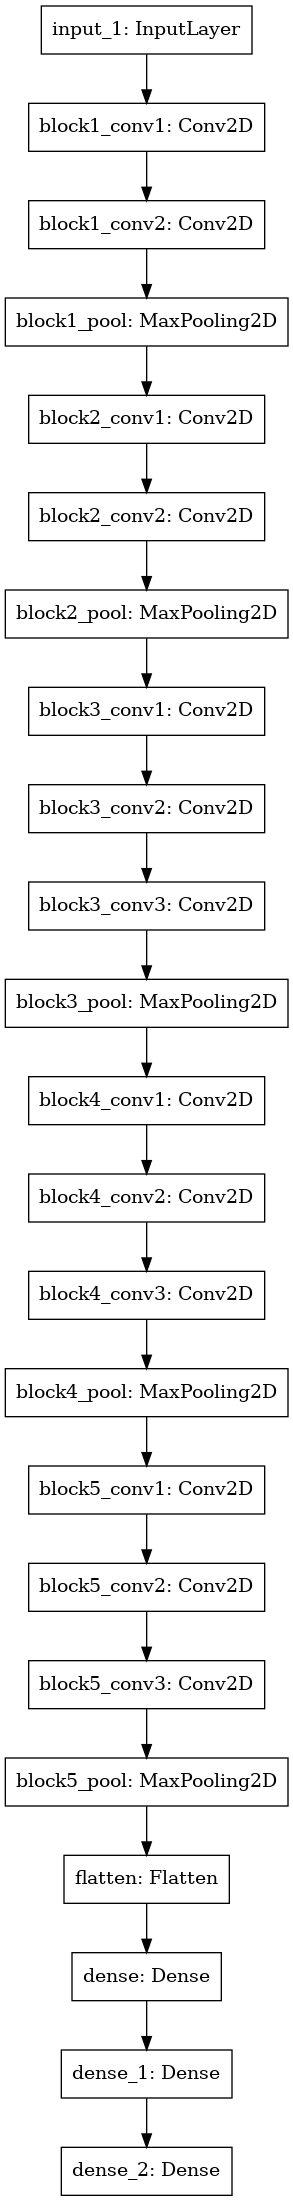

In [12]:
# all layers before are locked
for layer in vgg.layers:
  layer.trainable = False


x = Flatten()(vgg.output)
x = Dense(4096, activation='sigmoid')(x)
x = Dense(4096, activation='sigmoid')(x)
prediction = Dense(5, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model.summary()
tf.keras.utils.plot_model( model , to_file='architecture.png' )



# with tpu_strategy.scope():
#     x = Flatten()(vgg.output)
#     x = Dense(4096, activation='sigmoid')(x)
#     x = Dense(4096, activation='sigmoid')(x)
#     prediction = Dense(5, activation='softmax')(x)
#     model = Model(inputs=vgg.input, outputs=prediction)
    
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [13]:
from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

history = model.fit(train_generator,
                    epochs=NR_EPOCHS,
                    validation_data=val_generator,
                    callbacks = [tensorboard_callback, checkpoint]
                    )


2022-09-12 13:15:28.356143: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-09-12 13:15:30.578316: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/297 [..............................] - ETA: 1:02:42 - loss: 2.0632 - sparse_categorical_accuracy: 0.0312

2022-09-12 13:15:41.139501: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-12 13:15:41.139739: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/297 [..............................] - ETA: 2:51 - loss: 7.5324 - sparse_categorical_accuracy: 0.2812   

2022-09-12 13:15:41.689962: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-12 13:15:41.690568: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-09-12 13:15:41.831188: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 145 callback api events and 142 activity events. 
2022-09-12 13:15:41.839423: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-12 13:15:41.857489: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tblogs/age_model_22-09-12_13-15/train/plugins/profile/2022_09_12_13_15_41

2022-09-12 13:15:41.862525: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tblogs/age_model_22-09-12_13-15/train/plugins/profile/2022_09_12_13_15_41/949d5726e12b.trace.json.gz
2022-09-12 13:15:41.884246: I tensorflow/core/profiler/rpc/cli

297/297 [==============================] - 189s 597ms/step - loss: 1.5364 - sparse_categorical_accuracy: 0.5291 - val_loss: 1.0058 - val_sparse_categorical_accuracy: 0.6779

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.67792, saving model to ./models/age_best_model.h5
Epoch 2/60
297/297 [==============================] - 88s 297ms/step - loss: 0.8527 - sparse_categorical_accuracy: 0.6830 - val_loss: 0.8023 - val_sparse_categorical_accuracy: 0.7123

Epoch 00002: val_sparse_categorical_accuracy improved from 0.67792 to 0.71226, saving model to ./models/age_best_model.h5
Epoch 3/60
297/297 [==============================] - 80s 270ms/step - loss: 0.7093 - sparse_categorical_accuracy: 0.7242 - val_loss: 0.7231 - val_sparse_categorical_accuracy: 0.7089

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.71226
Epoch 4/60
297/297 [==============================] - 87s 292ms/step - loss: 0.6754 - sparse_categorical_accuracy: 0.7328 - val_loss: 0.7621 - 

### Plot Training and Validation Loss

In [14]:
# print keys 
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

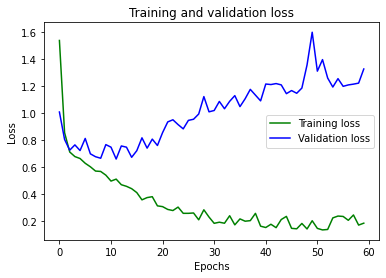

In [15]:
NR_EPOCHS = len(history.history['loss'])
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(NR_EPOCHS)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

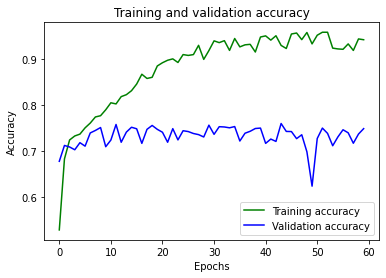

In [16]:
loss_train = history.history['sparse_categorical_accuracy']
loss_val = history.history['val_sparse_categorical_accuracy']
epochs = range(NR_EPOCHS)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Load model and validate

In [17]:
model_age = load_model("./models/age_best_model.h5")
loss, acc = model_age.evaluate(test_generator)
print (loss, acc)

23/23 [==============================] - 15s 657ms/step - loss: 1.2831 - sparse_categorical_accuracy: 0.7435
1.283054232597351 0.7434996366500854


### Show sample results

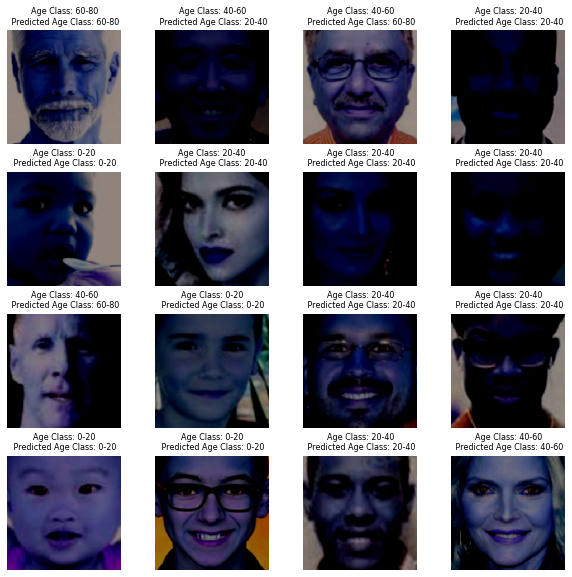

In [18]:
def show_faces(images, age=None, pred_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Age": [pred_age, age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.axis('off')
        #plt.xticks([])
        #plt.yticks([])
        #plt.grid(False)
        plt.imshow(images[i])
        
        if pred_age[i] is None:
            continue
           
            
        real_age = int(age[i])
        predicted_age = np.argmax(predicted[i])
                
                
        plt.title(f"Age Class: {age_dict[real_age]}\n Predicted Age Class: {age_dict[predicted_age]}", fontsize=8)
            
        plt.subplots_adjust(wspace=0.3)

sample_validation_images, sample_validation_labels = next(test_generator)
predicted = model_age.predict(sample_validation_images)
show_faces(sample_validation_images, age=sample_validation_labels, pred_age=predicted)

## Direct Age Estimation

In [19]:
NR_EPOCHS = 60

In [20]:
# reads image_path and returns decoded img 
def process_path(file_path, label):
    #read file path
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    #convert the values from 0-1
    img = tf.image.convert_image_dtype(img, tf.float32)
    # preprocess image for VGG16
    img = preprocess_input(img)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img, label

### Split Dataset in Train, Validation and Test Dataset

In [21]:
labels_train =  tf.keras.utils.to_categorical(training_data['age'], num_classes=117)
labels_val =  tf.keras.utils.to_categorical(val_data['age'], num_classes=117)
labels_test =  tf.keras.utils.to_categorical(testing_data['age'], num_classes=117) 

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((training_data['image'],labels_train))
train_dataset = train_dataset.shuffle(len(training_data))
train_dataset =train_dataset.map(process_path, num_parallel_calls=4)
train_dataset = train_dataset.batch(64)


val_dataset = tf.data.Dataset.from_tensor_slices((val_data['image'],labels_val))
val_dataset = val_dataset.shuffle(len(val_data))
val_dataset = val_dataset.map(process_path, num_parallel_calls=4)
val_dataset = val_dataset.batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((testing_data['image'],labels_test))
test_dataset = test_dataset.shuffle(len(testing_data))
test_dataset = test_dataset.map(process_path, num_parallel_calls=4)
test_dataset = test_dataset.batch(64)

### Load and build model

In [23]:
model2 = VGG16(input_shape=[224,224,3],weights='imagenet', include_top=False)

for layer in model.layers:
    layer.trainable=False

In [24]:
x2 = Flatten()(model2.output)
x2 = Dense(4096, activation='sigmoid')(x2)
x2 = Dense(4096, activation='sigmoid')(x2)
prediction2 = Dense(117, activation='softmax')(x2)
model_direct = Model(inputs=model2.input, outputs=prediction2)
model_direct.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [25]:
# model_direct.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss=tf.keras.metrics.SparseCategoricalCrossentropy(),
#               metrics= tf.keras.metrics.MeanAbsoluteError())

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6)
model_direct.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [26]:

DIRECT_PATH = "./models/direct_age_aug_best_model.h5"


checkpoint = tf.keras.callbacks.ModelCheckpoint(DIRECT_PATH, 
                                                monitor='val_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')

import datetime
log_dir = '../tblogs/direct_age_model_aug' + datetime.datetime.now().strftime('%y-%m-%d_%H-%M')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

log_dir

2022-09-12 14:52:55.314811: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-12 14:52:55.319954: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-12 14:52:55.536239: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-12 14:52:55.536429: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


'../tblogs/direct_age_model_aug22-09-12_14-52'

In [27]:
from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

history_direct = model_direct.fit(train_dataset,
                    epochs=NR_EPOCHS,
                    batch_size = 64,
                    validation_data=val_dataset,
                    callbacks = [tensorboard_callback, checkpoint]
                    )


Epoch 1/60
  1/297 [..............................] - ETA: 21:10 - loss: 5.3070 - accuracy: 0.0000e+00

2022-09-12 14:53:02.038149: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-12 14:53:02.038196: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/297 [..............................] - ETA: 3:24 - loss: 12.0235 - accuracy: 0.0391    

2022-09-12 14:53:02.830253: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-12 14:53:02.831287: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-09-12 14:53:02.968950: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 609 callback api events and 606 activity events. 
2022-09-12 14:53:02.983180: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-12 14:53:03.006696: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tblogs/direct_age_model_aug22-09-12_14-52/train/plugins/profile/2022_09_12_14_53_02

2022-09-12 14:53:03.021942: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tblogs/direct_age_model_aug22-09-12_14-52/train/plugins/profile/2022_09_12_14_53_02/949d5726e12b.trace.json.gz
2022-09-12 14:53:03.050197: I tensorflow/c

297/297 [==============================] - 136s 445ms/step - loss: 4.9264 - accuracy: 0.0432 - val_loss: 5.5625 - val_accuracy: 0.0093

Epoch 00001: val_accuracy improved from -inf to 0.00934, saving model to ./models/direct_age_aug_best_model.h5
Epoch 2/60
297/297 [==============================] - 131s 440ms/step - loss: 4.6330 - accuracy: 0.0386 - val_loss: 5.3367 - val_accuracy: 0.0919

Epoch 00002: val_accuracy improved from 0.00934 to 0.09190, saving model to ./models/direct_age_aug_best_model.h5
Epoch 3/60
297/297 [==============================] - 128s 431ms/step - loss: 4.6235 - accuracy: 0.0424 - val_loss: 5.2645 - val_accuracy: 0.0919

Epoch 00003: val_accuracy did not improve from 0.09190
Epoch 4/60
297/297 [==============================] - 131s 439ms/step - loss: 4.6319 - accuracy: 0.0434 - val_loss: 5.0481 - val_accuracy: 0.0235

Epoch 00004: val_accuracy did not improve from 0.09190
Epoch 5/60
297/297 [==============================] - 131s 439ms/step - loss: 4.6309 - a

### Plot Training and Validation Loss

In [28]:
history_direct.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

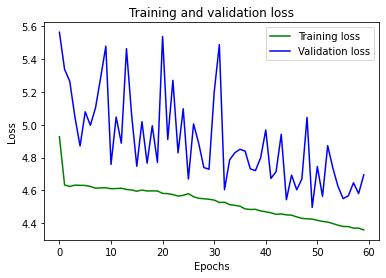

In [29]:
NR_EPOCHS = len(history_direct.history['loss'])
loss_train_direct = history_direct.history['loss']
loss_val_direct = history_direct.history['val_loss']
epochs = range(NR_EPOCHS)
plt.plot(epochs, loss_train_direct, 'g', label='Training loss')
plt.plot(epochs, loss_val_direct, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

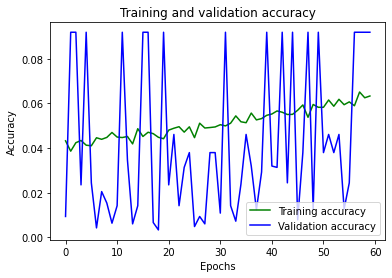

In [30]:
loss_train_direct = history_direct.history['accuracy']
loss_val_direct = history_direct.history['val_accuracy']
epochs = range(NR_EPOCHS)
plt.plot(epochs, loss_train_direct, 'g', label='Training accuracy')
plt.plot(epochs, loss_val_direct, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
model_age_direct = load_model("./models/direct_age_aug_best_model.h5")
loss, acc = model_age_direct.evaluate(test_dataset)
print(loss, acc)

23/23 [==============================] - 4s 173ms/step - loss: 5.3304 - accuracy: 0.0935
5.330394268035889 0.09346450865268707
